# Visualize deformation results (test deformer module)

## Imports and Utility function for rendering

In [31]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch3d.renderer import (
            PerspectiveCameras, RasterizationSettings,
            DirectionalLights, MeshRasterizer, MeshRenderer, HardFlatShader, 
            TexturesVertex
)
sys.path.append(os.path.join(os.getcwd(), ".."))

output_dir = "./outputs/deformation_visualizer"

In [33]:
NUM_SHELLS = 5

In [34]:
def normalize_vecs(vectors: torch.Tensor) -> torch.Tensor:
    """
    Normalize vector lengths.
    """
    return vectors / (torch.norm(vectors, dim=-1, keepdim=True))
    
def create_cam2world_matrix(forward_vector, origin):
    """Takes in the direction the camera is pointing and the camera origin and returns a cam2world matrix."""
    forward_vector = normalize_vecs(forward_vector)
    up_vector = torch.tensor([0, 1, 0], dtype=torch.float, device=origin.device).expand_as(forward_vector)

    right_vector = -normalize_vecs(torch.cross(up_vector, forward_vector, dim=-1))
    up_vector = normalize_vecs(torch.cross(forward_vector, right_vector, dim=-1))

    rotation_matrix = torch.eye(4, device=origin.device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    rotation_matrix[:, :3, :3] = torch.stack((right_vector, up_vector, forward_vector), axis=-1)

    translation_matrix = torch.eye(4, device=origin.device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    translation_matrix[:, :3, 3] = origin
    cam2world = (translation_matrix @ rotation_matrix)[:, :, :]
    assert(cam2world.shape[1:] == (4, 4))
    return cam2world

class LookAtPoseSampler:

    @staticmethod
    def sample(horizontal_mean, vertical_mean, lookat_position, horizontal_stddev=0, vertical_stddev=0, radius=1, batch_size=1, device='cpu'):
        h = torch.randn((batch_size, 1), device=device) * horizontal_stddev + horizontal_mean
        v = torch.randn((batch_size, 1), device=device) * vertical_stddev + vertical_mean
        v = torch.clamp(v, 1e-5, math.pi - 1e-5)

        theta = h
        v = v / math.pi
        phi = torch.arccos(1 - 2*v)

        camera_origins = torch.zeros((batch_size, 3), device=device)

        camera_origins[:, 0:1] = radius*torch.sin(phi) * torch.cos(math.pi-theta)
        camera_origins[:, 2:3] = radius*torch.sin(phi) * torch.sin(math.pi-theta)
        camera_origins[:, 1:2] = radius*torch.cos(phi)

        # forward_vectors = normalize_vecs(-camera_origins)
        forward_vectors = normalize_vecs(lookat_position - camera_origins)
        return create_cam2world_matrix(forward_vectors, camera_origins)
        

def setup_cameras(device, img_size=None, pose=None, intrinsics=None):
    if intrinsics is None:
        focal_length = 4.2647 * 2
        intrinsics = torch.zeros((4, 4), device=device)
        intrinsics[[0, 1], [0, 1]] = -focal_length
        intrinsics[2, 3] = 1.0
        intrinsics[3, 2] = 1.0
        intrinsics = intrinsics[None]
    else:
        raise NotImplementedError

    if pose is None:
        yaw = 0.0
        pitch = 0.0
        pose = LookAtPoseSampler.sample(3.14/2 + yaw, 3.14/2 + pitch, torch.tensor([0, -0.2, 0]), radius=8.6)
    else:
        pose = pose.reshape(-1, 4, 4)

    world2cam = pose.clone()
    # world2cam[:, [0, 1]] *= -1
    # world2cam = -1 * world2cam
    world2cam = world2cam.inverse()
    # intrinsics = torch.tensor([[focal_length, 0, 0.5], [0, focal_length, 0.5], [0, 0, 1]])
    cameras = PerspectiveCameras(device=device, R=world2cam[:, :3, :3], T=world2cam[:, :3, 3],
                                 K=intrinsics, in_ndc=True)
    return cameras

device = "cuda"
img_size = 256
pose = None
cameras = setup_cameras(device, img_size=img_size, pose=pose)
raster_settings = RasterizationSettings(
    image_size=img_size,
    blur_radius=0.0,
    faces_per_pixel=1,
)
mesh_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardFlatShader(
        device=device,
        cameras=cameras,
        lights=DirectionalLights(device=device,
                                 ambient_color=((0.2, 0.2, 0.2),),
                                 diffuse_color=((0.6, 0.6, 0.8),),
                                 specular_color=((0.2, 0.2, 0.0),),
                                 direction=[[0.5,1,1.5]])
    )
)

def render_meshes(meshes, cameras):
    MESH_COLOR = [50, 168, 168]    
    verts_rgb = torch.ones_like(meshes.verts_padded()).to(device)
    verts_rgb[...,0] = MESH_COLOR[0]/255
    verts_rgb[...,1] = MESH_COLOR[1]/255
    verts_rgb[...,2] = MESH_COLOR[2]/255
    meshes.textures = TexturesVertex(verts_features=verts_rgb)
    mesh_img = mesh_renderer(meshes, cameras=cameras)[:,:,:,:3]
    mesh_img = (mesh_img * 255).clamp(0, 255).to(torch.uint8).cpu().numpy()
    return mesh_img

## Set up correspondences

In [35]:
import torch

from deformer.smpl_deformer import Deformer, smpl_init_kwargs
from deformer.util import (get_shell_verts_from_base,                                     
                           point_mesh_barycentric_coordinates,
                           weights_from_k_closest_verts,
                           PointMeshCorrespondence,
                           )
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj, save_obj

TEMPLATE_SCALE = 1.0
TEMPLATE_TRANS = [0, 0, 0]
ASSET_DIR = "../assets"
PATH_BASE = os.path.join(ASSET_DIR, 'smpl', 'smpl_uv_no_hands_feet_ear.obj')
deformer = Deformer(**smpl_init_kwargs, 
                    scale=TEMPLATE_SCALE,
                    transl=torch.tensor(TEMPLATE_TRANS))

device = "cuda"
deformer.smplx_model = deformer.smplx_model.to(device)
smpl_template_verts = deformer.smplx_model().vertices

os.makedirs(output_dir, exist_ok=True)
save_obj(os.path.join(output_dir, 'smpl_template.obj'), smpl_template_verts.detach().cpu()[0], deformer.smplx_model.faces_tensor.detach().cpu())

In [36]:
shell_base_verts, shell_faces, aux = load_obj(PATH_BASE, load_textures=False)
shell_base_verts = shell_base_verts * TEMPLATE_SCALE
shell_base_verts += torch.tensor([TEMPLATE_TRANS])
shell_faces = shell_faces.verts_idx.to(device=device)
shell_base_verts = shell_base_verts[None]
shell_base_verts = shell_base_verts.to(device=device)
shell_base_vnormals = Meshes(shell_base_verts, shell_faces[None]).verts_normals_padded()

# Implementation of 1
# Deform the shell using closest k points. Compute correspondence for all shells using the base custom template and smpl template
shell_vertices = get_shell_verts_from_base(
    shell_base_verts,
    shell_faces,
    offset_len=0.03,
    num_shells=NUM_SHELLS,
)
shell_v_template = get_shell_verts_from_base(
    smpl_template_verts,
    deformer.smplx_model.faces_tensor,
    offset_len=0.03,
    num_shells=NUM_SHELLS,
)
shell_vnormals = Meshes(shell_base_verts, shell_faces[None]).verts_normals_padded()
smpl_template_vnormals = Meshes(smpl_template_verts, deformer.smplx_model.faces_tensor[None]).verts_normals_padded()
point_verts_weights, point_verts_idxs = weights_from_k_closest_verts(
    shell_base_verts,
    smpl_template_verts, 
    k=5,
    points_normals=shell_vnormals,
    verts_normals=smpl_template_vnormals,
    normal_weight=0.1,    
)
mesh_shells_template = Meshes(shell_v_template[0], deformer.smplx_model.faces_tensor[None].expand(NUM_SHELLS, -1, -1))
shells_correspondence = PointMeshCorrespondence(shell_vertices[0], 
                                                meshes=mesh_shells_template
                                                )


# Implementation of 2
# compute correspondence for each shell between each custom template and flame template
# inflating templates
shell_vnormals = Meshes(shell_vertices[0], shell_faces[None].expand(NUM_SHELLS, -1, -1)).verts_normals_padded()
shell_bary_coords_m2, face_idxs_m2 = point_mesh_barycentric_coordinates(
    shell_vertices[0],
    shell_v_template[0], 
    deformer.smplx_model.faces_tensor,
    # point_normals=shell_vnormals,
    return_packed=False,
)

print(torch.allclose(shells_correspondence.bary_coords, shell_bary_coords_m2))
print(torch.allclose(shells_correspondence.face_idxs, face_idxs_m2))


True
True


## Visualize correspondence

In [37]:
src_verts = shells_correspondence.backproject(mesh_shells_template)

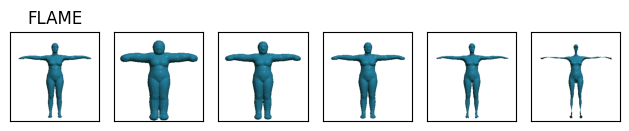

In [38]:

shells_init = Meshes(torch.cat([shell_base_verts, src_verts], 0), shell_faces[None].expand(src_verts.shape[0]+shell_base_verts.shape[0], -1, -1))
mesh_img = render_meshes(shells_init, cameras=cameras)

fig, axs = plt.subplots(1, len(shells_init))
fig.set_tight_layout(True)
for i, ax in enumerate(axs):
    ax.imshow(mesh_img[i])
    if i == 0:
        ax.set_title('FLAME')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

plt.show()

# Visualization

## First Part: visualize shell meshes

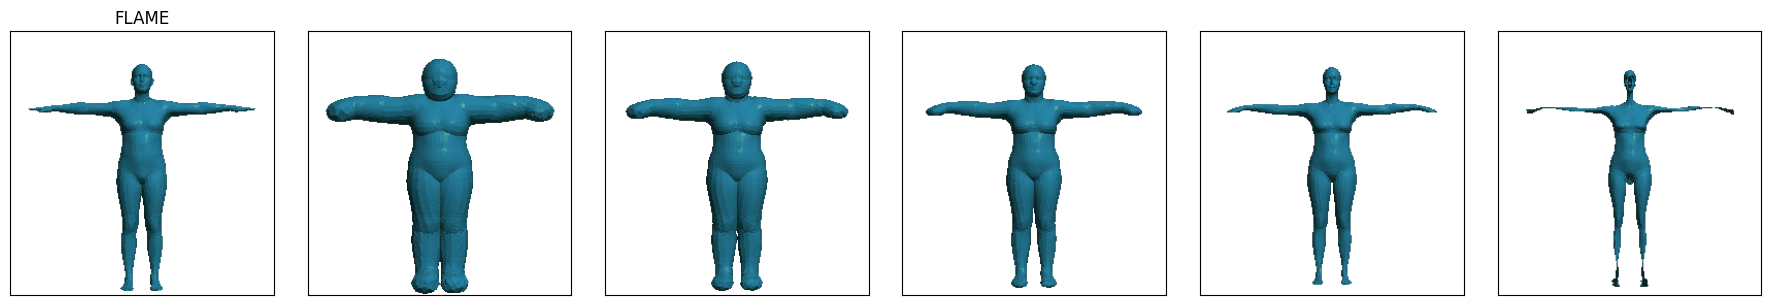

In [39]:
MESH_COLOR = [50, 168, 168]
shells_init = Meshes([smpl_template_verts[0].cuda()] + list(torch.unbind(shell_vertices[0], dim=0)), [deformer.smplx_model.faces_tensor] + [shell_faces]*NUM_SHELLS)
mesh_img = render_meshes(shells_init, cameras=cameras)

fig, axs = plt.subplots(1, 6, figsize=(18, 3))
fig.set_tight_layout(True)
for i, ax in enumerate(axs):
    ax.imshow(mesh_img[i])
    if i == 0:
        ax.set_title('FLAME')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

plt.show()

## Visualize shell deformation

In [40]:
# Internal function to generate images based on attributes
# tmp = np.random.rand(img_size, img_size)
@torch.no_grad()
def render_internal(shp_params, pose_params):        
    shp_params = torch.from_numpy(shp_params).to(device, dtype=torch.float32).reshape([1, -1])
    pose_params = torch.from_numpy(pose_params).to(device, dtype=torch.float32).reshape([1, (deformer.smplx_model.NUM_BODY_JOINTS+1)*3])
    
    _, shell_deformed_verts = deformer.run(
        betas=shp_params.expand(NUM_SHELLS, -1),        
        global_orient=pose_params[:, :3].expand(NUM_SHELLS, -1),
        body_pose=pose_params[:, 3:].expand(NUM_SHELLS, -1),
        deform_using_k_verts=True,  
        v_template=shell_v_template[0],  # NUM_SHELLS, N_points, 3      
        point_verts_idxs=point_verts_idxs.expand(NUM_SHELLS, -1, -1),
        point_verts_weights=point_verts_weights.expand(NUM_SHELLS, -1, -1),
        point_mesh_correspondence=shells_correspondence,
    )
    shell_deformed_verts = shell_deformed_verts.reshape(NUM_SHELLS, shell_vertices.shape[-2], 3)
    images_m1 = render_meshes(Meshes(shell_deformed_verts, shell_faces[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    outputs, shell_deformed_verts = deformer.run(
        betas=shp_params.expand(NUM_SHELLS, -1),        
        global_orient=pose_params[:, :3].expand(NUM_SHELLS, -1),
        body_pose=pose_params[:, 3:].expand(NUM_SHELLS, -1),        
        v_template=shell_v_template[0],  # NUM_SHELLS, N_points, 3
        bary_coords=shell_bary_coords_m2.expand(NUM_SHELLS, -1, -1),
        point_face_idxs=face_idxs_m2,
        point_mesh_correspondence=shells_correspondence,
    )
    flame_deformed_verts = outputs.vertices
    images_m2_template = render_meshes(Meshes(flame_deformed_verts, deformer.smplx_model.faces_tensor[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    images_m2 = render_meshes(Meshes(shell_deformed_verts, shell_faces[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    return ("m1", images_m1), ("m2 template", images_m2_template), ("m2", images_m2), shell_deformed_verts

# Initialize output widget
out = widgets.Output()

# Render function
def render(*args):    
    shp_params = np.concatenate([np.array([slider.value for slider in slider_set_shape]), np.zeros(deformer.smplx_model.num_betas-10)])
    pose_params = np.concatenate([np.array([slider.value for slider in slider_set_pose]), np.zeros((deformer.smplx_model.NUM_BODY_JOINTS+1)*3-len(slider_set_pose))])
    
    image_sets = render_internal(shp_params, pose_params)    
    with out:
        tmp = image_sets[-1].flatten().cpu().numpy()[:10]
        image_sets = image_sets[:-1]
        clear_output(wait=True)
        fig, axs = plt.subplots(len(image_sets), len(image_sets[0][1]), figsize=(3*len(image_sets[0][1]), 3*len(image_sets)))
        fig.set_tight_layout(True)
        for row, image_set in enumerate(image_sets):
            label = image_set[0]
            image_set = image_set[1]
            for col, image in enumerate(image_set):                
                ax = axs[row, col]
                ax.imshow(image)
                ax.set_title(label)
                ax.axes.get_xaxis().set_ticks([])
                ax.axes.get_yaxis().set_ticks([])
        plt.show()

# Creating 3 sets of 10 sliders
sliders = []
# slider_set_expression = [widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description=f'exp_{id:03d}', continuous_update=False) for id in range(10)]
# for id, slider in enumerate(slider_set_expression):
#     slider.observe(render, names=f'value')
# sliders.append(slider_set_expression)
slider_set_shape = [widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description=f'sh_{id:03d}', continuous_update=False) for id in range(10)]
for id, slider in enumerate(slider_set_shape):
    slider.observe(render, names=f'value')
sliders.append(slider_set_shape)
slider_set_pose = [widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description=f'pose_{id:03d}', continuous_update=False) for id in range(10)]
for id, slider in enumerate(slider_set_pose):
    slider.observe(render, names=f'value')
sliders.append(slider_set_pose)

# Group sliders visually
slider_boxes = [widgets.VBox(slider_set) for slider_set in sliders]
slider_group = widgets.HBox(slider_boxes)

# Display the sliders and output
display(out, slider_group)

# Initial Rendering
render()

Output()

## Next Part: Deform trained Gaussians

In [48]:
# Load training result
import sys
import os
import pickle
import torch.nn as nn
sys.path.append(os.path.join(os.getcwd(), ".."))
from scene.gaussian_model_tets import GaussianModel, TetPoints
from gaussian_renderer import render as render_gaussian
from utils.graphics_utils import getWorld2View2, getProjectionMatrix
import numpy as np

log_dir = "./outputs/test_gaussian_shells_snapshotpeople"

with open(os.path.join(log_dir, 'gaussians.pkl'), 'rb') as f:
  gaussians = pickle.load(f)

with open(os.path.join(log_dir, 'point_list.pkl'), 'rb') as f:
  points_list = pickle.load(f)



In [49]:
class Camera(nn.Module):
    def __init__(self, 
                 R, T, FoVx, FoVy, 
                 # image, gt_alpha_mask,
                 img_width, img_height,
                 trans=np.array([0.0, 0.0, 0.0]), scale=1.0, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy

        try:
            self.data_device = torch.device(data_device)
        except Exception as e:
            print(e)
            print(f"[Warning] Custom device {data_device} failed, fallback to default cuda device" )
            self.data_device = torch.device("cuda")

        self.image_width = img_width
        self.image_height = img_height

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        self.world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).to(self.data_device)
        self.projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy).transpose(0,1).to(self.data_device)
        self.full_proj_transform = (self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]        

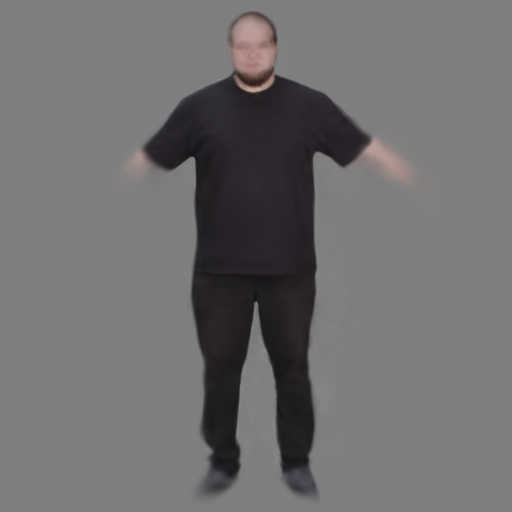

In [50]:
from PIL import Image
import torch
from utils.graphics_utils import fov2focal,focal2fov
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import PointsRenderer, PointsRasterizationSettings, PointsRasterizer, AlphaCompositor


bg_color = [0.5, 0.5, 0.5]
background = torch.tensor(bg_color, dtype=torch.float32, device= 'cuda:0')

camera_id = 0
cameras_data = np.load(os.path.join(log_dir, 'cameras.npz'))
world2cam = cameras_data["world2cam"]
FovX = cameras_data["FovX"]
FovY = cameras_data["FovY"]
camera = Camera(world2cam[camera_id][:3,:3].T, world2cam[camera_id][:3, 3], FovX, FovY, 512, 512, data_device=background.device)

class PipelineParams():
    def __init__(self):
        self.convert_SHs_python = True
        self.compute_cov3D_python = False
        self.debug = False

pipeline = PipelineParams()

rendering = render_gaussian(camera, gaussians, pipeline, background)["render"]
im = np.uint8(rendering.detach().permute(1,2,0).cpu().numpy()*255)
display(Image.fromarray(np.concatenate([im], axis=1)))


In [51]:
shell_base_verts, shell_faces, aux = load_obj(PATH_BASE, load_textures=False)
shell_base_verts = shell_base_verts * TEMPLATE_SCALE
shell_base_verts += torch.tensor([TEMPLATE_TRANS])
shell_faces = shell_faces.verts_idx.to(device=device)
shell_base_verts = shell_base_verts[None]
shell_base_verts = shell_base_verts.to(device=device)
shell_base_vnormals = Meshes(shell_base_verts, shell_faces[None]).verts_normals_padded()

# Implementation of 1
# Deform the shell using closest k points. Compute correspondence for all shells using the base custom template and smpl template
shell_vertices = get_shell_verts_from_base(
    shell_base_verts,
    shell_faces,
    offset_len=0.1,  # Note this must be the same as during the training
    num_shells=NUM_SHELLS,
)
shell_v_template = get_shell_verts_from_base(
    smpl_template_verts,
    deformer.smplx_model.faces_tensor,
    offset_len=0.1,
    num_shells=NUM_SHELLS,
)
shell_vnormals = Meshes(shell_base_verts, shell_faces[None]).verts_normals_padded()
smpl_template_vnormals = Meshes(smpl_template_verts, deformer.smplx_model.faces_tensor[None]).verts_normals_padded()
point_verts_weights, point_verts_idxs = weights_from_k_closest_verts(
    shell_base_verts,
    smpl_template_verts, 
    k=5,
    points_normals=shell_vnormals,
    verts_normals=smpl_template_vnormals,
    normal_weight=0.1,    
)
mesh_shells_template = Meshes(shell_v_template[0], deformer.smplx_model.faces_tensor[None].expand(NUM_SHELLS, -1, -1))
shells_correspondence = PointMeshCorrespondence(shell_vertices[0], 
                                                meshes=mesh_shells_template
                                                )

In [52]:
# Visualize 0 deformation gaussians
from deformer.smpl_deformer import Deformer
from deformer.util import interpolate_mesh_from_bary_coords

# exp_params = torch.zeros((1, deformer.n_expression_params), device=device, dtype=torch.float32)
shp_params = torch.zeros((1, deformer.smplx_model.num_betas), device=device, dtype=torch.float32)
pose_params = torch.zeros((1, (deformer.smplx_model.NUM_BODY_JOINTS+1)*3), device=device, dtype=torch.float32)

smpl_output, shell_deformed_verts = deformer.run(
        betas=shp_params.expand(NUM_SHELLS, -1),        
        global_orient=pose_params[:, :3].expand(NUM_SHELLS, -1),
        body_pose=pose_params[:, 3:].expand(NUM_SHELLS, -1),        
        deform_using_k_verts=True,  
        v_template=shell_v_template[0],  # NUM_SHELLS, N_points, 3      
        point_verts_idxs=point_verts_idxs.expand(NUM_SHELLS, -1, -1),
        point_verts_weights=point_verts_weights.expand(NUM_SHELLS, -1, -1),
        point_mesh_correspondence=shells_correspondence,
    )

new_xyz = interpolate_mesh_from_bary_coords(shell_deformed_verts.reshape(1, -1, 3).cpu(), points_list.faces, points_list.tet_bari.reshape(1, -1, 4)).squeeze(0)

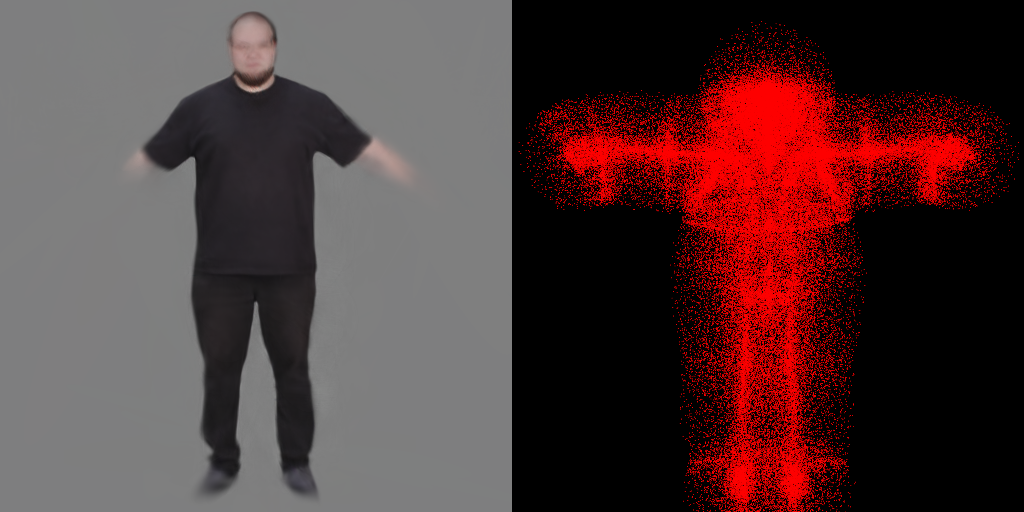

In [58]:
# Set gaussians
xyz_bk = gaussians._xyz.data.clone()
assert new_xyz.shape == gaussians.get_xyz.shape
gaussians._xyz.data[:] = new_xyz.to(device=gaussians._xyz.device)

_rendering = render_gaussian(camera, gaussians, pipeline, background)["render"]
_im = np.uint8(rendering.detach().permute(1,2,0).cpu().numpy()*255)

raster_settings = PointsRasterizationSettings(
    image_size=(camera.image_width, camera.image_height), 
    radius = 0.003,
    points_per_pixel = 10
)

# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
point_renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)
pnt_rgb = torch.zeros_like(gaussians.get_xyz)
pnt_rgb[..., 0] = 1.0
point_cloud = Pointclouds(points=[gaussians.get_xyz], features=[pnt_rgb])
pnts_img = np.uint8(point_renderer(point_cloud, cameras=cameras)[0].cpu().numpy()*255)
display(Image.fromarray(np.concatenate([_im, pnts_img], axis=1)))

# Restore gaussians
gaussians._xyz.data[:] = xyz_bk.to(device=gaussians._xyz.device)

## Visualize interactively

In [62]:
from gaussian_renderer import render as render_gaussian
from pytorch3d.renderer import PointsRenderer

def render_gaussian_f(gaussians, camera):
    rendering = render_gaussian(camera, gaussians, pipeline, background)["render"]
    im = np.uint8(rendering.detach().permute(1,2,0).cpu().numpy()*255)
    return im

def render_gaussian_p(gaussians, camera):
    pnt_rgb = torch.zeros_like(gaussians.get_xyz)
    pnt_rgb[..., 0] = 1.0
    point_cloud = Pointclouds(points=[gaussians.get_xyz], features=[pnt_rgb])
    pnts_img = np.uint8(point_renderer(point_cloud, cameras=cameras)[0].cpu().numpy()*255)
    return pnts_img
    
# Internal function to generate images based on attributes
# tmp = np.random.rand(img_size, img_size)
def render_internal(shp_params, pose_params):        
    shp_params = torch.from_numpy(shp_params).to(device, dtype=torch.float32).reshape([1, -1])
    pose_params = torch.from_numpy(pose_params).to(device, dtype=torch.float32).reshape([1, -1])
    
    smpl_output, shell_deformed_verts = deformer.run(
        betas=shp_params.expand(NUM_SHELLS, -1),        
        global_orient=pose_params[:, :3].expand(NUM_SHELLS, -1),
        body_pose=pose_params[:, 3:].expand(NUM_SHELLS, -1),        
        deform_using_k_verts=True,  
        v_template=shell_v_template[0],  # NUM_SHELLS, N_points, 3      
        point_verts_idxs=point_verts_idxs.expand(NUM_SHELLS, -1, -1),
        point_verts_weights=point_verts_weights.expand(NUM_SHELLS, -1, -1),
        point_mesh_correspondence=shells_correspondence,
    )
    flame_deformed_verts = smpl_output.vertices
    images_flame = render_meshes(Meshes(flame_deformed_verts, deformer.smplx_model.faces_tensor[None].expand(flame_deformed_verts.shape[0], -1, -1)), cameras=cameras)[0]
    images_shell = render_meshes(Meshes(shell_deformed_verts[:1], shell_faces[None]), cameras=cameras)[0]
    shell_deformed_verts = shell_deformed_verts.reshape(-1, 3)
    new_xyz = interpolate_mesh_from_bary_coords(shell_deformed_verts.reshape(1, -1, 3).cpu(), points_list.faces, points_list.tet_bari.reshape(1, -1, 4)).squeeze(0)    
    assert new_xyz.shape == gaussians.get_xyz.shape
    gaussians._xyz.data[:] = new_xyz.to(device=gaussians._xyz.device)
    images_m1 = render_gaussian_f(gaussians, camera)
    images_pnts = render_gaussian_p(gaussians, cameras)
    
    outputs, shell_deformed_verts = deformer.run(
        betas=shp_params.expand(NUM_SHELLS, -1),        
        global_orient=pose_params[:, :3].expand(NUM_SHELLS, -1),
        body_pose=pose_params[:, 3:].expand(NUM_SHELLS, -1),        
        v_template=shell_v_template[0],  # NUM_SHELLS, N_points, 3
        bary_coords=shell_bary_coords_m2.expand(NUM_SHELLS, -1, -1),
        point_face_idxs=face_idxs_m2,
        point_mesh_correspondence=shells_correspondence,
    )
    # images_shell = render_meshes(Meshes(shell_deformed_verts[:1], shell_faces[None]), cameras=cameras)[0]
    shell_deformed_verts = shell_deformed_verts.reshape(-1, 3)
    new_xyz = interpolate_mesh_from_bary_coords(shell_deformed_verts.reshape(1, -1, 3).cpu(), points_list.faces, points_list.tet_bari.reshape(1, -1, 4)).squeeze(0)        
    assert new_xyz.shape == gaussians.get_xyz.shape
    gaussians._xyz.data[:] = new_xyz.to(device=gaussians._xyz.device)
    # images_m2_template = render_meshes(Meshes(flame_deformed_verts, deformer.smplx_model.faces_tensor[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    # images_m2 = render_meshes(Meshes(shell_deformed_verts, shell_faces[None].expand(NUM_SHELLS, -1, -1)), cameras=cameras)
    images_m2 = render_gaussian_f(gaussians, camera)
    return ("ref", images_flame), ("shell", images_shell), ("xyz", images_pnts), ("m1", images_m1), ("m2", images_m2), gaussians

# Initialize output widget
out = widgets.Output()

# Render function
def render(*args):
    shp_params = np.concatenate([np.array([slider.value for slider in slider_set_shape]), np.zeros(deformer.smplx_model.num_betas-10)])
    pose_params = np.concatenate([np.array([slider.value for slider in slider_set_pose]), np.zeros((deformer.smplx_model.NUM_BODY_JOINTS+1)*3-len(slider_set_pose))])
    images = render_internal(shp_params, pose_params)    
    with out:
        # tmp = image_sets[:-1][1].flatten().cpu().numpy()[:10]
        images = images[:-1]
        clear_output(wait=True)
        fig, axs = plt.subplots(1, len(images), figsize=(5*len(images), 5))        
        for col, lbl_image in enumerate(images):                
            ax = axs[col]
            label, image = lbl_image
            ax.imshow(image)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
            ax.set_title(label)
        plt.show()

# Creating 3 sets of 10 sliders
sliders = []
# slider_set_expression = [widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description=f'exp_{id:03d}', continuous_update=False) for id in range(10)]
# for id, slider in enumerate(slider_set_expression):
#     slider.observe(render, names=f'value')
# sliders.append(slider_set_expression)
slider_set_shape = [widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description=f'sh_{id:03d}', continuous_update=False) for id in range(10)]
for id, slider in enumerate(slider_set_shape):
    slider.observe(render, names=f'value')
sliders.append(slider_set_shape)
slider_set_pose = [widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description=f'pose_{id:03d}', continuous_update=False) for id in range(6)]
for id, slider in enumerate(slider_set_pose):
    slider.observe(render, names=f'value')
sliders.append(slider_set_pose)

# Create a button for resetting sliders
reset_button = widgets.Button(description="Reset Sliders")

# Group sliders visually
slider_boxes = [widgets.VBox(slider_set) for slider_set in sliders]
slider_group = widgets.HBox(slider_boxes)

# Define function to reset all sliders to initial value
def reset_values(button):
    for slider_set in sliders:
        for slider in slider_set:
            slider.value = 0.0

# Add reset function to button click event
reset_button.on_click(reset_values)

# Display the sliders and output
display(reset_button, out, slider_group)

# Initial Rendering
render()

Button(description='Reset Sliders', style=ButtonStyle())

Output()